In [3]:
import geopandas as gp
import pandas as pd
import pathlib
import numpy as np
from shapely.geometry import LineString, MultiLineString, Point
from shapely import ops
import libpysal
from datetime import datetime
from tqdm import tqdm
import random

# load data frames
import load_data_module

In [4]:
# Load preprocessed data
raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf = load_data_module.raw_full_trip_gdf, load_data_module.raw_trip_sp_gdf, load_data_module.raw_trip_ep_gdf

raw_full_trip_gdf

,PERSON_ID,TRIP_ID,TRIP_START,TRIP_END,TRIP_LEN_IN_MTRS,TRIP_DURATION_IN_SECS,geometry,TRIP_WD,TRIP_DATE
0,16348,985222,2022-10-31 09:15:57,2022-10-31 09:34:08,2574,1090,"LINESTRING (13.50497 52.45445, 13.50498 52.454...",Monday,2022-10-31
1,16348,985223,2022-10-31 11:04:22,2022-10-31 11:09:12,353,290,"LINESTRING (13.52685 52.45699, 13.52685 52.457...",Monday,2022-10-31
2,16348,985301,2022-10-31 11:38:24,2022-10-31 11:43:51,315,327,"LINESTRING (13.52438 52.45529, 13.52433 52.455...",Monday,2022-10-31
3,16348,985302,2022-10-31 12:01:50,2022-10-31 12:12:00,335,608,"LINESTRING (13.52601 52.45596, 13.52601 52.455...",Monday,2022-10-31
4,16348,985459,2022-10-31 13:23:11,2022-10-31 13:53:17,3503,1803,"LINESTRING (13.52692 52.45710, 13.52694 52.457...",Monday,2022-10-31
...,...,...,...,...,...,...,...,...,...
1380,17269,1003131,2022-11-07 15:01:30,2022-11-07 15:09:31,676,481,"LINESTRING (13.32606 52.51031, 13.32632 52.510...",Monday,2022-11-07
1381,17269,1003715,2022-11-07 16:58:18,2022-11-07 17:44:12,10514,2748,"LINESTRING (13.24104 52.52562, 13.24102 52.525...",Monday,2022-11-07
1382,17269,1006304,2022-11-09 17:50:05,2022-11-09 18:17:57,10279,1670,"LINESTRING (13.13320 52.56350, 13.13332 52.563...",Wednesday,2022-11-09
1383,17269,1009686,2022-11-12 14:03:45,2022-11-12 16:50:44,35594,10014,"LINESTRING (13.13360 52.56364, 13.13321 52.563...",Saturday,2022-11-12


In [5]:
tesselation_gdf = gp.read_file("W:/Master-Thesis-Repository/data/freemove_dlr_data/tessellation.geojson")

In [6]:
print(f"Number of unique users in data: {raw_full_trip_gdf.PERSON_ID.unique().size}\nNumber of Trips: {raw_full_trip_gdf.TRIP_ID.unique().size}\nNumber of Start Points: {raw_trip_sp_gdf.TRIP_ID.unique().size}\nNumber of End Points: {raw_trip_ep_gdf.TRIP_ID.unique().size}")

Number of unique users in data: 62
Number of Trips: 1024
Number of Start Points: 1024
Number of End Points: 1024


# Get trajectories that happened during the same time

In [180]:
def getTripOverlaps(gdf):
    time_overlap_dict = {}
    for index_x, trip_x in tqdm(gdf.iterrows(), total=len(gdf)):
        overlaps = []
        ts_x = pd.to_datetime(trip_x['TRIP_START'], format='%Y-%m-%d %H:%M:%S')
        te_x = pd.to_datetime(trip_x['TRIP_END'], format='%Y-%m-%d %H:%M:%S')
        i = 0

        for index_y, trip_y in gdf.iterrows():
            ts_y = pd.to_datetime(trip_y['TRIP_START'], format='%Y-%m-%d %H:%M:%S')
            te_y = pd.to_datetime(trip_y['TRIP_END'], format='%Y-%m-%d %H:%M:%S')

            if ts_x <= ts_y and te_x >= ts_y and (trip_x.TRIP_ID != trip_y.TRIP_ID): 
                overlaps.append(trip_y['TRIP_ID'])
            else:
                pass
            
        time_overlap_dict[trip_x['TRIP_ID']] = overlaps

    return time_overlap_dict


In [179]:
getTripOverlaps(trip_merged_gdf)

100%|██████████| 695/695 [01:42<00:00,  6.79it/s]


# From Start Points (SPs)

In [7]:
# Generate home locations (HL) from SPs
raw_trip_sp_gdf.index=pd.to_datetime(raw_trip_sp_gdf.TRIP_START)
raw_trip_sp_gdf['hl'] = raw_trip_sp_gdf['TRIP_START'].apply(lambda x: 1 if x in raw_trip_sp_gdf.between_time('6:00', '10:00').TRIP_START else 0).astype(object)
raw_trip_sp_gdf.reset_index(inplace=True, drop=True)
raw_trip_sp_gdf

,PERSON_ID,TRIP_ID,TRIP_START,TRIP_END,TRIP_LEN_IN_MTRS,TRIP_DURATION_IN_SECS,TRIP_SP,TRIP_WD,TRIP_DATE,LONG,LAT,hl
0,16348,985222,2022-10-31 09:15:57,2022-10-31 09:34:08,2574,1090,POINT (13.50497 52.45445),Monday,2022-10-31,13.504967,52.454451,1
1,16348,985223,2022-10-31 11:04:22,2022-10-31 11:09:12,353,290,POINT (13.52685 52.45699),Monday,2022-10-31,13.526849,52.456990,0
2,16348,985301,2022-10-31 11:38:24,2022-10-31 11:43:51,315,327,POINT (13.52438 52.45529),Monday,2022-10-31,13.524382,52.455285,0
3,16348,985302,2022-10-31 12:01:50,2022-10-31 12:12:00,335,608,POINT (13.52601 52.45596),Monday,2022-10-31,13.526006,52.455956,0
4,16348,985459,2022-10-31 13:23:11,2022-10-31 13:53:17,3503,1803,POINT (13.52692 52.45710),Monday,2022-10-31,13.526920,52.457104,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1019,17269,1003131,2022-11-07 15:01:30,2022-11-07 15:09:31,676,481,POINT (13.32606 52.51031),Monday,2022-11-07,13.326065,52.510312,0
1020,17269,1003715,2022-11-07 16:58:18,2022-11-07 17:44:12,10514,2748,POINT (13.24104 52.52562),Monday,2022-11-07,13.241043,52.525623,0
1021,17269,1006304,2022-11-09 17:50:05,2022-11-09 18:17:57,10279,1670,POINT (13.13320 52.56350),Wednesday,2022-11-09,13.133199,52.563501,0
1022,17269,1009686,2022-11-12 14:03:45,2022-11-12 16:50:44,35594,10014,POINT (13.13360 52.56364),Saturday,2022-11-12,13.133599,52.563643,0


In [8]:
# Spatial join points to polygons
gdf_sp = gp.sjoin(
    tesselation_gdf[["tile_id", "geometry"]],
    raw_trip_sp_gdf,
    how="inner"
).drop('index_right', axis=1)

In [9]:
# Extract only those cells that are HL
gdf_hl_sp = gdf_sp[gdf_sp['hl'] == 1]

In [10]:
# create spatial weights matrix
W = libpysal.weights.Queen.from_dataframe(gdf_hl_sp)

# get component labels
components = W.component_labels

gdf_hl_combined_sp = pd.merge(gp.sjoin(
    gdf_hl_sp,
    gdf_hl_sp.dissolve(by=components)[["geometry"]],
    how="left"
), gdf_hl_sp.dissolve(by=components)[["geometry"]].reset_index(), left_on="index_right", right_on='index', suffixes=("__drop", "")).drop(['index', 'index_right', 'geometry__drop'], axis=1)

c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 65 disconnected components.
 There are 40 islands with ids: 0, 1, 2, 3, 4, 11, 12, 13, 18, 19, 20, 21, 22, 23, 39, 41, 42, 46, 47, 48, 62, 63, 68, 69, 75, 76, 77, 78, 79, 80, 98, 106, 107, 110, 120, 121, 122, 123, 128, 129.
  warnings.warn(message)


In [11]:
# Compute count of unique HL per Peson (HL here is already the merged tiles)
gdf_hl_combined_sp = pd.merge(gdf_hl_combined_sp, gdf_hl_combined_sp.groupby('PERSON_ID')[['TRIP_ID']].nunique().reset_index().rename(columns={'TRIP_ID': 'CNT_UNIQUE_HL'}), how="left")

# TODO: Add number of trips per merged tile
#gdf_hl_combined_sp = pd.merge(gdf_hl_combined_sp, gdf_hl_combined_sp.groupby(['PERSON_ID', 'geometry']).nunique().reset_index()[['PERSON_ID', 'TRIP_ID']].rename(columns={'TRIP_ID': 'CNT_TRIPS_PER_HL'}), suffixes=("", "_drop"))

# using dictionary to convert specific columns
convert_dict = {'PERSON_ID': object,
                'CNT_UNIQUE_HL': int
                }
 
gdf_hl_combined_sp = gdf_hl_combined_sp.astype(convert_dict)

In [ ]:
gdf_hl_combined_sp.explore(column='PERSON_ID')

# From End Points (EPs)

<AxesSubplot: ylabel='Frequency'>

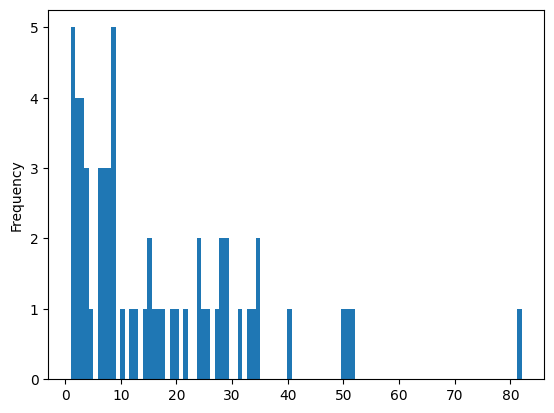

In [749]:
raw_trip_ep_gdf.groupby('PERSON_ID').count().TRIP_ID.plot.hist(bins=100)

<AxesSubplot: ylabel='Frequency'>

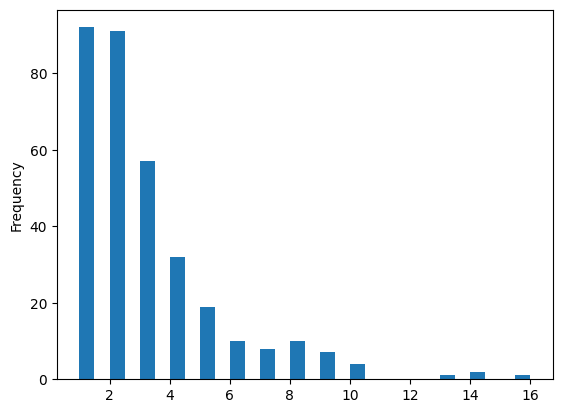

In [750]:
raw_trip_ep_gdf.groupby(['PERSON_ID', 'TRIP_DATE']).count().reset_index('TRIP_DATE').TRIP_ID.plot.hist(bins=30)

In [12]:
# Generate home locations (HL) from EPs
raw_trip_ep_gdf.index=pd.to_datetime(raw_trip_ep_gdf.TRIP_END)
raw_trip_ep_gdf['hl'] = raw_trip_ep_gdf['TRIP_END'].apply(lambda x: 1 if x in raw_trip_ep_gdf.between_time('16:00', '00:00').TRIP_END else 0).astype(object)
raw_trip_ep_gdf.reset_index(inplace=True, drop=True)
raw_trip_ep_gdf

,PERSON_ID,TRIP_ID,TRIP_START,TRIP_END,TRIP_LEN_IN_MTRS,TRIP_DURATION_IN_SECS,TRIP_EP,TRIP_WD,TRIP_DATE,LONG,LAT,hl
0,16348,985222,2022-10-31 09:15:57,2022-10-31 09:34:08,2574,1090,POINT (13.52725 52.45754),Monday,2022-10-31,13.527252,52.457538,0
1,16348,985223,2022-10-31 11:04:22,2022-10-31 11:09:12,353,290,POINT (13.52514 52.45550),Monday,2022-10-31,13.525136,52.455497,0
2,16348,985301,2022-10-31 11:38:24,2022-10-31 11:43:51,315,327,POINT (13.52620 52.45604),Monday,2022-10-31,13.526203,52.456038,0
3,16348,985302,2022-10-31 12:01:50,2022-10-31 12:12:00,335,608,POINT (13.52681 52.45710),Monday,2022-10-31,13.526806,52.457104,0
4,16348,985459,2022-10-31 13:23:11,2022-10-31 13:53:17,3503,1803,POINT (13.50058 52.45610),Monday,2022-10-31,13.500579,52.456100,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1019,17269,1003131,2022-11-07 15:01:30,2022-11-07 15:09:31,676,481,POINT (13.32746 52.51156),Monday,2022-11-07,13.327458,52.511557,0
1020,17269,1003715,2022-11-07 16:58:18,2022-11-07 17:44:12,10514,2748,POINT (13.13391 52.56367),Monday,2022-11-07,13.133908,52.563666,1
1021,17269,1006304,2022-11-09 17:50:05,2022-11-09 18:17:57,10279,1670,POINT (13.19253 52.54677),Wednesday,2022-11-09,13.192528,52.546766,1
1022,17269,1009686,2022-11-12 14:03:45,2022-11-12 16:50:44,35594,10014,POINT (13.13360 52.56364),Saturday,2022-11-12,13.133599,52.563643,1


In [13]:
# Spatial join points to polygons
gdf_ep = gp.sjoin(
    tesselation_gdf[["tile_id", "geometry"]],
    raw_trip_ep_gdf,
    how="inner"
).drop('index_right', axis=1)

In [14]:
# Extract only those cells that are HL
gdf_hl_ep = gdf_ep[gdf_ep['hl'] == 1]

In [15]:
### Merge hl cells that are adjacent (touching) to each other 

# create spatial weights matrix
W = libpysal.weights.Queen.from_dataframe(gdf_hl_ep)

# get component labels
components = W.component_labels

gdf_hl_combined_ep = pd.merge(gp.sjoin(
    gdf_hl_ep,
    gdf_hl_ep.dissolve(by=components)[["geometry"]],
    how="left"
), gdf_hl_ep.dissolve(by=components)[["geometry"]].reset_index(), left_on="index_right", right_on='index', suffixes=("__drop", "")).drop(['index', 'index_right', 'geometry__drop'], axis=1)

c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 188 disconnected components.
 There are 89 islands with ids: 0, 5, 8, 9, 41, 44, 50, 60, 68, 72, 73, 74, 78, 101, 102, 112, 119, 120, 121, 125, 130, 141, 145, 148, 149, 150, 163, 173, 183, 187, 192, 193, 194, 202, 203, 222, 226, 234, 242, 247, 263, 268, 269, 270, 271, 272, 279, 283, 284, 285, 288, 293, 295, 298, 299, 300, 304, 308, 309, 310, 311, 316, 317, 348, 349, 352, 375, 376, 377, 388, 396, 397, 398, 414, 431, 435, 442, 443, 450, 453, 467, 470, 471, 472, 473, 479, 480, 487, 488.
  warnings.warn(message)


In [16]:
gdf_hl_combined_ep = pd.merge(gdf_hl_combined_ep, gdf_hl_combined_ep.groupby('PERSON_ID')[['TRIP_ID']].nunique().reset_index().rename(columns={'TRIP_ID': 'CNT_UNIQUE_HL'}), how="left")

# using dictionary to convert specific columns
convert_dict = {'PERSON_ID': object,
                'CNT_UNIQUE_HL': int
                }
 
gdf_hl_combined_ep = gdf_hl_combined_ep.astype(convert_dict)

In [ ]:
gdf_hl_combined_ep[gdf_hl_combined_ep['PERSON_ID'] == 16363]

In [ ]:
gdf_hl_combined_ep[gdf_hl_combined_ep['PERSON_ID'] == 16363].explore(column='PERSON_ID')

# Merge (inner join)

In [468]:
# Spatial join points to 
gdf_hl_combined = gp.sjoin(
    gdf_hl_combined_ep[["geometry"]],
    gdf_hl_combined_sp,
    how="inner"
).drop_duplicates(subset=['PERSON_ID', 'TRIP_ID']).drop('index_right', axis=1)

In [469]:
# get number of unique HL per user
gdf_hl_combined = pd.merge(gdf_hl_combined, gdf_hl_combined.astype({'geometry':'string'}).groupby('PERSON_ID').nunique().reset_index()[['PERSON_ID', 'geometry']].rename(columns={'geometry': 'CNT_UNIQUE_HL'}), suffixes=("_drop", ""), how="left", left_on='PERSON_ID', right_on='PERSON_ID').drop('CNT_UNIQUE_HL_drop', axis=1)


In [470]:
gdf_hl_combined = pd.merge(gdf_hl_combined.astype({'geometry':'string'}), gdf_hl_combined.astype({'geometry':'string'}).groupby('geometry').count().reset_index().rename(columns={'tile_id': 'CNT_TRIPS_PER_GEOM'})[['geometry', 'CNT_TRIPS_PER_GEOM']], left_on="geometry", right_on="geometry")
geometry = gp.GeoSeries.from_wkt(gdf_hl_combined['geometry'])
gdf_hl_combined = gp.GeoDataFrame(gdf_hl_combined, geometry=geometry)


In [413]:
# Get the trips that are from PERSON_IDs that overlap in their hl
intersected_person_id = pd.merge(gdf_hl_combined.astype({'geometry':'string'}), gdf_hl_combined.astype({'geometry':'string'}).groupby(['geometry'])[['PERSON_ID']].nunique().reset_index(), left_on="geometry", right_on="geometry", how="left")
intersected_person_id = intersected_person_id[intersected_person_id.PERSON_ID_y > 1]
intersected_person_id

,geometry,tile_id,PERSON_ID_x,TRIP_ID,TRIP_START,TRIP_END,TRIP_LEN_IN_MTRS,TRIP_DURATION_IN_SECS,TRIP_WD,TRIP_DATE,LONG,LAT,hl,CNT_UNIQUE_HL,CNT_TRIPS_PER_GEOM,PERSON_ID_y
3,MULTIPOLYGON (((13.19814022115662 52.531346546...,228016,16659,1004199,2022-11-08 07:25:09,2022-11-08 08:02:23,9099,2233,Tuesday,2022-11-08,13.199311,52.532641,1,2,4,2
4,MULTIPOLYGON (((13.19814022115662 52.531346546...,227372,16356,1013650,2022-11-16 09:31:22,2022-11-16 10:07:36,9546,2172,Wednesday,2022-11-16,13.196940,52.531809,1,1,4,2
5,MULTIPOLYGON (((13.19814022115662 52.531346546...,227372,16356,992654,2022-11-03 08:41:46,2022-11-03 08:53:46,1061,720,Thursday,2022-11-03,13.196940,52.531809,1,1,4,2
6,MULTIPOLYGON (((13.19814022115662 52.531346546...,227372,16356,985179,2022-10-31 09:29:04,2022-10-31 10:02:12,9624,1986,Monday,2022-10-31,13.197644,52.531802,1,1,4,2
24,MULTIPOLYGON (((13.325700991501593 52.51166923...,274293,16656,1002751,2022-11-07 09:51:43,2022-11-07 09:55:28,819,223,Monday,2022-11-07,13.327644,52.512145,1,3,2,2
25,MULTIPOLYGON (((13.325700991501593 52.51166923...,273651,16972,1006129,2022-11-09 09:43:13,2022-11-09 10:15:13,7980,1918,Wednesday,2022-11-09,13.325718,52.513387,1,2,2,2
46,MULTIPOLYGON (((13.34726055832046 52.547737578...,280755,16970,992614,2022-11-03 08:59:51,2022-11-03 09:33:54,7811,2028,Thursday,2022-11-03,13.347083,52.546729,1,1,8,2
47,MULTIPOLYGON (((13.34726055832046 52.547737578...,280755,16643,1009255,2022-11-12 09:37:11,2022-11-12 09:56:50,5788,1179,Saturday,2022-11-12,13.345915,52.547440,1,1,8,2
48,MULTIPOLYGON (((13.34726055832046 52.547737578...,280755,16643,986203,2022-11-01 08:12:21,2022-11-01 08:55:42,18097,2535,Tuesday,2022-11-01,13.345830,52.547472,1,1,8,2
49,MULTIPOLYGON (((13.34726055832046 52.547737578...,280755,16643,1006736,2022-11-10 09:22:15,2022-11-10 10:05:08,14635,2568,Thursday,2022-11-10,13.345649,52.547704,1,1,8,2


<AxesSubplot: ylabel='Frequency'>

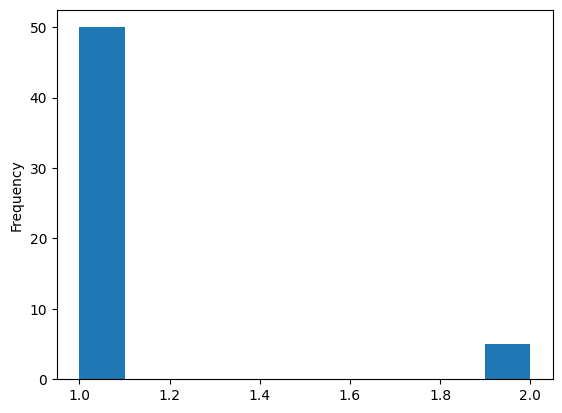

In [442]:
gdf_hl_combined.astype({'geometry':'string'}).groupby(['geometry'])[['PERSON_ID']].nunique().PERSON_ID.plot.hist()

In [471]:
gdf_hl_combined.PERSON_ID.unique().size

42

In [472]:
gdf_hl_combined.explore(column="PERSON_ID")

c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\geopandas\explore.py:362: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  cat = pd.Categorical(gdf[column][~nan_idx], categories=categories)


# Merge (concatenate)

In [17]:
gp_combined_concat = pd.concat([gdf_hl_combined_ep, gdf_hl_combined_sp])

<AxesSubplot: ylabel='Frequency'>

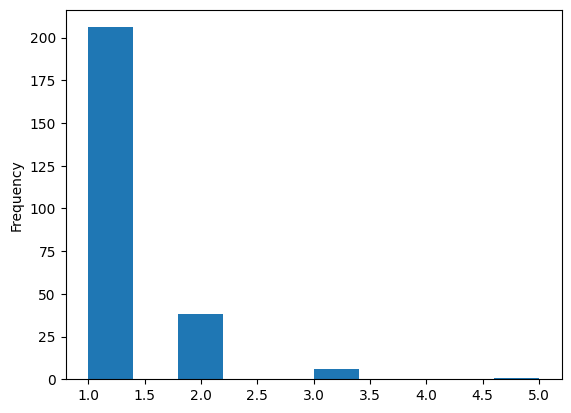

In [18]:
gp_combined_concat.astype({'geometry':'string'}).groupby(['geometry'])[['PERSON_ID']].nunique().PERSON_ID.plot.hist()

In [421]:
intersected_person_id = pd.merge(gp_combined_concat.astype({'geometry':'string'}), gp_combined_concat.astype({'geometry':'string'}).groupby(['geometry'])[['PERSON_ID']].nunique().reset_index(), left_on="geometry", right_on="geometry", how="left")
intersected_person_id = intersected_person_id[intersected_person_id.PERSON_ID_y > 1]
intersected_person_id.head(3)

,tile_id,PERSON_ID_x,TRIP_ID,TRIP_START,TRIP_END,TRIP_LEN_IN_MTRS,TRIP_DURATION_IN_SECS,TRIP_WD,TRIP_DATE,LONG,LAT,hl,geometry,CNT_UNIQUE_HL,PERSON_ID_y
6,180305,16657,988316,2022-11-01 17:05:36,2022-11-01 17:42:44,26015,2227,Tuesday,2022-11-01,13.066742,52.391942,1,"POLYGON ((13.06518955910693 52.392323785996, 1...",7,2
7,180948,16363,1005358,2022-11-08 16:50:43,2022-11-08 17:17:44,4820,1617,Tuesday,2022-11-08,13.067531,52.391377,1,"POLYGON ((13.06518955910693 52.392323785996, 1...",21,2
17,225457,17269,1006304,2022-11-09 17:50:05,2022-11-09 18:17:57,10279,1670,Wednesday,2022-11-09,13.192528,52.546766,1,MULTIPOLYGON (((13.190953698883664 52.54773757...,7,2
18,225457,16659,996509,2022-11-04 17:42:51,2022-11-04 17:53:25,500,634,Friday,2022-11-04,13.192309,52.547137,1,MULTIPOLYGON (((13.190953698883664 52.54773757...,24,2
19,226101,16659,996380,2022-11-04 17:18:11,2022-11-04 17:41:38,3618,1404,Friday,2022-11-04,13.194456,52.548648,1,MULTIPOLYGON (((13.190953698883664 52.54773757...,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,280756,16643,1008464,2022-11-11 09:58:12,2022-11-11 10:46:59,14619,2910,Friday,2022-11-11,13.345655,52.547906,1,"POLYGON ((13.34726055832046 52.54664503306836,...",8,2
727,289094,16655,1008100,2022-11-11 06:42:34,2022-11-11 09:16:55,342511,9254,Friday,2022-11-11,13.368985,52.524915,1,"POLYGON ((13.36882012513933 52.52588150977575,...",1,2
728,289094,16363,987381,2022-11-01 09:09:32,2022-11-01 09:34:36,23323,1444,Tuesday,2022-11-01,13.369835,52.525330,1,"POLYGON ((13.36882012513933 52.52588150977575,...",8,2
778,304549,17266,994920,2022-11-04 09:53:40,2022-11-04 09:56:38,666,178,Friday,2022-11-04,13.413664,52.550753,1,MULTIPOLYGON (((13.413735889345306 52.54992258...,4,2


In [ ]:
se_trips = pd.concat([raw_trip_sp_gdf.rename(columns={'TRIP_SP': 'geometry'}), raw_trip_ep_gdf.rename(columns={'TRIP_EP': 'geometry'})]).astype({'TRIP_ID':'object', 'PERSON_ID':'object'}).sort_values('TRIP_ID')


se_trips[se_trips['PERSON_ID'].isin(random.sample(se_trips.PERSON_ID.to_list(), 10))].explore(column="PERSON_ID", marker_kwds=dict(radius=10, fill=True))

In [760]:
gp_combined_concat.PERSON_ID.unique().size

58

In [429]:
intersected_person_id[['PERSON_ID_x', 'PERSON_ID_y']].drop_duplicates()

,PERSON_ID_x,PERSON_ID_y
6,16657,2
7,16363,2
17,17269,2
18,16659,2
30,16356,2
...,...,...
540,16646,2
544,17249,3
545,16653,3
567,16952,2


In [19]:
# Assign ID to HL
gp_combined_concat['HL_ID'] = gp_combined_concat.astype({'geometry': 'string'}).groupby('geometry').ngroup()

HL_table = gp_combined_concat[['geometry', 'HL_ID']].drop_duplicates()

# Check matching rate for Concatenated tiles

In [20]:
# Merge all start and enpoints of all trajectories with HL tiles
matched_sp = gp.sjoin(
    raw_trip_sp_gdf,
    gp_combined_concat.dissolve()[['geometry']], # Here we do the matching on the dissolved HL tiles since we only want to have one match per point to detect binary whether it is matched at all or not
    how="left"
).rename(columns={"index_right": "matched_sp"})

matched_ep = gp.sjoin(
    raw_trip_ep_gdf,
    gp_combined_concat.dissolve()[['geometry']], # same here, see above
    how="left"
).rename(columns={"index_right": "matched_ep"})


In [21]:
# Get unmatched start and endpoints
unmatched_sp = matched_sp[matched_sp.matched_sp.isnull()].TRIP_ID.to_list()
unmatched_ep = matched_ep[matched_ep.matched_ep.isnull()].TRIP_ID.to_list()

In [22]:
# Number of unmatched trajectories that do not start or end in an HL tile
len(raw_full_trip_gdf.query('TRIP_ID in @unmatched_sp and TRIP_ID in @unmatched_ep'))

144

In [ ]:
raw_full_trip_gdf[raw_full_trip_gdf.TRIP_ID == 1007230].explore()

In [ ]:
# Plot unmatched trajectories and OD points
m = gp_combined_concat.explore(column="PERSON_ID")

raw_full_trip_gdf.query('TRIP_ID in @unmatched_sp and TRIP_ID in @unmatched_ep').astype({'TRIP_ID': 'object'}).explore(m=m)

raw_trip_sp_gdf.explore(m=m, color="green")

raw_trip_ep_gdf.explore(m=m, color="blue")

# Merge Subsequent Locations

In [135]:
joined_tile = None
cont = None

mapping_cont_trips = []

for index, trip in gdf_ep.sort_values('TRIP_ID').iterrows():
    te_1_id = trip.TRIP_ID
    te_1_tid = trip.tile_id
    te_1_dt = pd.to_datetime(trip['TRIP_END'], format='%Y-%m-%d %H:%M:%S')
    ts_1_dt = pd.to_datetime(trip['TRIP_START'], format='%Y-%m-%d %H:%M:%S')

    inflow = gdf_ep.query("tile_id == @te_1_tid")
    inflow['TRIP_END'] = pd.to_datetime(inflow.TRIP_END, format='%Y-%m-%d %H:%M:%S')
    inflow['TRIP_START'] = pd.to_datetime(inflow.TRIP_START, format='%Y-%m-%d %H:%M:%S')
    inflow['INFLOW_HR_DIFF'] = inflow.TRIP_END.apply(lambda x: (x - te_1_dt).total_seconds()/3600)
    inflow = inflow.query("(INFLOW_HR_DIFF <= 4) and (INFLOW_HR_DIFF >= 4)") # Take trips 
    inflow = inflow.query("(TRIP_START > @te_1_dt) or (@ts_1_dt > TRIP_END)") # Ignore trips that have happened simultaneously

    # if more than one trip has arrived in +- hour window, then do not merge this trip
    if len(inflow) > 1:
        continue

    
    # Get all trips that started from same tile as t_1 has ended in
    ts_2 = gdf_sp.query("tile_id == @te_1_tid")

    # if trip has started in tesselation area but ended outside than there will be no endpoint (happened 1 time)
    if ts_2.empty:
        continue

    # get difference between two trips hours (seconds divided by 3600 gets hours)
    ts_2['TRIP_START'] = pd.to_datetime(ts_2.TRIP_START, format='%Y-%m-%d %H:%M:%S')
    ts_2['TRIP_END'] = pd.to_datetime(ts_2.TRIP_END, format='%Y-%m-%d %H:%M:%S')
 
    ts_2['hr_diff'] = ts_2['TRIP_START'].apply(lambda x: (x - te_1_dt).total_seconds()/3600)

    # Only consider trips that started within a certain time after the initial trip ended in the same tessellation tile
    ts_2 = ts_2[(ts_2['hr_diff'].astype(str).astype(float) <= 8) & (ts_2['hr_diff'].astype(str).astype(float) >= 0)]

    # Only consider trips that are not simultaneously
    ts_2 = ts_2.query("(TRIP_START > @te_1_dt) or (@ts_1_dt > TRIP_END)")

    # Only consider connection if exactly one trip started from same tile in time window
    if len(ts_2) == 1:
        mapping_cont_trips.append({
            'TRIP_ID': te_1_id,
            'TRIP_ID_CONT': ts_2.TRIP_ID.iloc[0]
        })
    

c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [136]:
len(mapping_cont_trips)

307

In [137]:
mistakes = []
for conn in mapping_cont_trips:
    trip_ids = [conn['TRIP_ID'],  conn['TRIP_ID_CONT']]
    unique_person = raw_full_trip_gdf.query("TRIP_ID in @trip_ids").PERSON_ID.nunique()

    if unique_person > 1:
        mistakes.append(raw_full_trip_gdf.query("TRIP_ID in @trip_ids"))
        print(raw_full_trip_gdf.query("TRIP_ID in @trip_ids"))
        print("wrong")

len(mistakes)

     PERSON_ID  TRIP_ID           TRIP_START             TRIP_END  \
837      16960   988358  2022-11-01 14:14:07  2022-11-01 16:56:16   
967      16972   987958  2022-11-01 13:01:53  2022-11-01 14:09:26   

     TRIP_LEN_IN_MTRS  TRIP_DURATION_IN_SECS  \
837              9295                   9727   
967             33895                   4050   

                                              geometry  TRIP_WD   TRIP_DATE  
837  LINESTRING (13.32591 52.51375, 13.32590 52.513...  Tuesday  2022-11-01  
967  LINESTRING (13.75384 52.51984, 13.75382 52.519...  Tuesday  2022-11-01  
wrong
      PERSON_ID  TRIP_ID           TRIP_START             TRIP_END  \
330       16649   989264  2022-11-02 08:26:00  2022-11-02 09:06:54   
1064      17248   990339  2022-11-02 10:54:54  2022-11-02 12:28:27   

      TRIP_LEN_IN_MTRS  TRIP_DURATION_IN_SECS  \
330               6645                   2450   
1064              1197                   5613   

                                               g

12

In [ ]:
pd.concat(mistakes, keys=list(range(1,len(mistakes)+1))).reset_index(level=1, drop=True).reset_index(names="CONN_ID").head(6).explore(column="TRIP_ID")

In [60]:
def getTripChain(trip_id, chain=[]):
    """
    Recursive function that returns a list for all chained trips for a give orig trip_id
    """
    if type(trip_id) == str:
        trip_id = int(trip_id)

    # add orig trip_id to output list
    if len(chain) == 0:
        chain.append(trip_id)

    # recursively find all chained trips originating from the orig trip_id
    for edge in mapping_cont_trips:
        if edge['TRIP_ID'] == trip_id:
            chain.append(edge['TRIP_ID_CONT'])
            getTripChain(edge['TRIP_ID_CONT'], chain)
            
        
    return chain


getTripChain('998178')


[998178]

In [166]:
if set([1,2]).intersection(set([2,3])):
    print('lol')

lol


In [175]:
### Merge trips according to matching

# Get trip chain for each trip
trip_chains = [getTripChain(trip, chain=[]) for trip in gdf_sp.TRIP_ID]

# Sort for longest chain first
trip_chains.sort(key = len, reverse = True)

covered_trips = []
merged_trips_gdf = []
for chain in trip_chains:
    # Check if any of the trips in the current chain has already been merged as part of another chain
    if set(chain).intersection(set(covered_trips)):
        continue
    
    covered_trips += chain

    trips = raw_full_trip_gdf.query("TRIP_ID in @chain").sort_values("TRIP_START")
    trips["temp"] = 1

    trips = trips.groupby('temp').agg(list).reset_index(drop=True)

    trips["wkt_trip"] = trips['geometry'].apply(lambda x: ", ".join([str(i) for i in x]).replace("), LINESTRING (", ", "))
    trips['TRIP_START'] = trips['TRIP_START'].apply(lambda x: min(x))
    trips['TRIP_END'] = trips['TRIP_END'].apply(lambda x: max(x))
    trips['TRIP_LEN_IN_MTRS'] = trips['TRIP_LEN_IN_MTRS'].apply(lambda x: sum(x))
    trips['TRIP_DURATION_IN_SECS'] = trips['TRIP_DURATION_IN_SECS'].apply(lambda x: sum(x))
    trips['TRIP_WD'] = trips['TRIP_WD'].apply(lambda x: x[0])
    trips['TRIP_DATE'] = trips['TRIP_DATE'].apply(lambda x: x[0])
    trips['TRIP_ID'] = trips['TRIP_ID'].apply(lambda x: x[0])
    trips['PERSON_ID'] = trips['PERSON_ID'].apply(lambda x: x[0])
    trips = trips.drop('geometry', axis=1)

    trips = gp.GeoDataFrame(trips, geometry=gp.GeoSeries.from_wkt(trips['wkt_trip'])).drop('wkt_trip', axis=1)

    merged_trips_gdf.append(trips)

trip_merged_gdf = pd.concat(merged_trips_gdf)

In [176]:
trip_merged_gdf

,PERSON_ID,TRIP_ID,TRIP_START,TRIP_END,TRIP_LEN_IN_MTRS,TRIP_DURATION_IN_SECS,TRIP_WD,TRIP_DATE,geometry
0,17248,1000401,2022-11-06 00:21:26,2022-11-06 15:54:53,28124,23756,Sunday,2022-11-06,"LINESTRING (13.44404 52.50009, 13.44406 52.500..."
0,17248,998680,2022-11-05 11:18:33,2022-11-05 23:44:29,15017,5383,Saturday,2022-11-05,"LINESTRING (13.43277 52.48394, 13.43275 52.483..."
0,16348,1007064,2022-11-10 12:32:31,2022-11-10 20:55:05,40904,15937,Thursday,2022-11-10,"LINESTRING (13.49269 52.46984, 13.49267 52.469..."
0,16958,985207,2022-10-31 09:43:16,2022-10-31 16:55:04,32445,9765,Monday,2022-10-31,"LINESTRING (13.28880 52.51657, 13.28880 52.516..."
0,16664,992993,2022-11-03 12:21:52,2022-11-04 03:47:46,7575,4243,Thursday,2022-11-03,"LINESTRING (13.30944 52.52992, 13.30937 52.529..."
...,...,...,...,...,...,...,...,...,...
0,17266,1009434,2022-11-12 11:07:26,2022-11-12 13:43:45,42618,9370,Saturday,2022-11-12,"LINESTRING (13.59800 52.27785, 13.59810 52.277..."
0,16972,1006892,2022-11-10 09:21:57,2022-11-10 10:33:03,34081,4261,Thursday,2022-11-10,"LINESTRING (13.75352 52.51987, 13.75352 52.519..."
0,16972,985709,2022-10-31 17:48:48,2022-10-31 17:59:43,3194,655,Monday,2022-10-31,"LINESTRING (13.75445 52.52546, 13.75444 52.525..."
0,16972,999784,2022-11-05 17:49:52,2022-11-05 18:35:25,25821,2732,Saturday,2022-11-05,"LINESTRING (13.76090 52.52630, 13.76084 52.526..."


In [75]:
gdf_sp

,tile_id,geometry,PERSON_ID,TRIP_ID,TRIP_START,TRIP_END,TRIP_LEN_IN_MTRS,TRIP_DURATION_IN_SECS,TRIP_WD,TRIP_DATE,LONG,LAT,hl,CHAIN
31722,31722,"POLYGON ((12.65017 52.33637, 12.65017 52.33747...",16963,998178,2022-11-05 08:31:54,2022-11-05 11:25:14,306799,10396,Saturday,2022-11-05,12.651367,52.337018,1,998178
141123,141123,"POLYGON ((12.95560 52.43616, 12.95560 52.43725...",16657,992891,2022-11-03 11:47:30,2022-11-03 14:39:09,13072,10296,Thursday,2022-11-03,12.955835,52.436510,0,992891
160374,160374,"POLYGON ((13.00949 52.39342, 13.00949 52.39452...",16657,1005274,2022-11-08 18:31:46,2022-11-08 18:48:55,6678,1028,Tuesday,2022-11-08,13.010955,52.393532,0,1005274
164894,164894,"POLYGON ((13.02207 52.41425, 13.02207 52.41534...",16657,1005273,2022-11-08 17:51:38,2022-11-08 18:02:55,3854,677,Tuesday,2022-11-08,13.023055,52.415306,0,"1005273, 1005274"
167779,167779,"POLYGON ((13.02926 52.75592, 13.02926 52.75700...",16363,1011057,2022-11-13 19:00:13,2022-11-13 19:44:09,45556,2635,Sunday,2022-11-13,13.030424,52.756936,0,"1011057, 1011085, 1011086, 1011160"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426691,426691,"POLYGON ((13.75330 52.51932, 13.75330 52.52042...",16972,1005667,2022-11-09 06:58:11,2022-11-09 07:00:11,273,120,Wednesday,2022-11-09,13.753683,52.519917,1,"1005667, 1005924, 1006129"
426696,426696,"POLYGON ((13.75330 52.52479, 13.75330 52.52588...",16972,985709,2022-10-31 17:48:48,2022-10-31 17:59:43,3194,655,Monday,2022-10-31,13.754448,52.525464,0,985709
429269,429269,"POLYGON ((13.76049 52.52588, 13.76049 52.52697...",16972,999784,2022-11-05 17:49:52,2022-11-05 18:35:25,25821,2732,Saturday,2022-11-05,13.760897,52.526300,0,999784
429269,429269,"POLYGON ((13.76049 52.52588, 13.76049 52.52697...",16972,1005191,2022-11-08 13:07:32,2022-11-08 14:08:45,32769,3672,Tuesday,2022-11-08,13.761264,52.526422,0,1005191


In [71]:
already_chained_trips = []
gdf_sp['CHAIN'] = ""

for index, trip in gdf_sp.iterrows():
    trip_id = trip.TRIP_ID
    if trip_id not in already_chained_trips:
        chain = getTripChain(trip_id, chain=[])
        already_chained_trips += chain
        gdf_sp.at[index, 'CHAIN'] = str(chain).replace("[", "").replace("]", "")



gdf_sp 

,tile_id,geometry,PERSON_ID,TRIP_ID,TRIP_START,TRIP_END,TRIP_LEN_IN_MTRS,TRIP_DURATION_IN_SECS,TRIP_WD,TRIP_DATE,LONG,LAT,hl,CHAIN
31722,31722,"POLYGON ((12.65017 52.33637, 12.65017 52.33747...",16963,998178,2022-11-05 08:31:54,2022-11-05 11:25:14,306799,10396,Saturday,2022-11-05,12.651367,52.337018,1,998178
141123,141123,"POLYGON ((12.95560 52.43616, 12.95560 52.43725...",16657,992891,2022-11-03 11:47:30,2022-11-03 14:39:09,13072,10296,Thursday,2022-11-03,12.955835,52.436510,0,992891
160374,160374,"POLYGON ((13.00949 52.39342, 13.00949 52.39452...",16657,1005274,2022-11-08 18:31:46,2022-11-08 18:48:55,6678,1028,Tuesday,2022-11-08,13.010955,52.393532,0,1005274
164894,164894,"POLYGON ((13.02207 52.41425, 13.02207 52.41534...",16657,1005273,2022-11-08 17:51:38,2022-11-08 18:02:55,3854,677,Tuesday,2022-11-08,13.023055,52.415306,0,"1005273, 1005274"
167779,167779,"POLYGON ((13.02926 52.75592, 13.02926 52.75700...",16363,1011057,2022-11-13 19:00:13,2022-11-13 19:44:09,45556,2635,Sunday,2022-11-13,13.030424,52.756936,0,"1011057, 1011085, 1011086, 1011160"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426691,426691,"POLYGON ((13.75330 52.51932, 13.75330 52.52042...",16972,1005667,2022-11-09 06:58:11,2022-11-09 07:00:11,273,120,Wednesday,2022-11-09,13.753683,52.519917,1,"1005667, 1005924, 1006129"
426696,426696,"POLYGON ((13.75330 52.52479, 13.75330 52.52588...",16972,985709,2022-10-31 17:48:48,2022-10-31 17:59:43,3194,655,Monday,2022-10-31,13.754448,52.525464,0,985709
429269,429269,"POLYGON ((13.76049 52.52588, 13.76049 52.52697...",16972,999784,2022-11-05 17:49:52,2022-11-05 18:35:25,25821,2732,Saturday,2022-11-05,13.760897,52.526300,0,1005191
429269,429269,"POLYGON ((13.76049 52.52588, 13.76049 52.52697...",16972,1005191,2022-11-08 13:07:32,2022-11-08 14:08:45,32769,3672,Tuesday,2022-11-08,13.761264,52.526422,0,1005191


# Look into 1st Degree Destinations from HL tiles

In [146]:
sp_m = gp.sjoin(
    raw_trip_sp_gdf,
    HL_table,
    how="left"
).drop('index_right', axis=1)

In [156]:
test = sp_m[sp_m['HL_ID'] == 89]

In [180]:
def leftJoinHLId(gdf, geometry_name):
    return gp.sjoin(gp.GeoDataFrame(gdf, geometry=geometry_name), HL_table, how="left").drop('index_right', axis=1)

In [225]:
# Get first order end points per HL_ID
mapping_first_order = {
    'HL_ID_FROM': [],
    'PERSON_ID': [],
    'TRIP_ID': [],
    'TRIP_EP': []
}

for name, group in sp_m.groupby('HL_ID'):
    dest_list = []
    # iterate over each trip of HL group
    for index, row in group.iterrows():
        orig_trip_id = row.TRIP_ID

        dest = raw_trip_ep_gdf.query("TRIP_ID == @orig_trip_id")

        mapping_first_order['HL_ID_FROM'].append(name)
        mapping_first_order['TRIP_EP'].append(dest.TRIP_EP.iloc[0])
        mapping_first_order['TRIP_ID'].append(dest.TRIP_ID.iloc[0])
        mapping_first_order['PERSON_ID'].append(dest.PERSON_ID.iloc[0])
        

first_order_ep = pd.DataFrame(dict([(col_name,pd.Series(values)) for col_name,values in mapping_first_order.items()]))

first_order_ep = gp.GeoDataFrame(first_order_ep, geometry="TRIP_EP")
first_order_ep.head(3)

,HL_ID,PERSON_ID,TRIP_ID,TRIP_EP
0,1.0,16659,996569,POINT (13.18653 52.52158)
1,2.0,16356,985179,POINT (13.32365 52.51518)
2,2.0,16356,990138,POINT (13.32541 52.51166)


In [227]:
m = HL_table.query("HL_ID == 2").explore(column="HL_ID")

first_order_ep.query("HL_ID_FROM == 2").explore(m=m, column="PERSON_ID", marker_kwds=dict(radius=3, fill=True))

c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\mapclassify\classifiers.py:891: RuntimeWarning: invalid value encountered in scalar divide
  gadf = 1 - self.adcm / adam
